In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [5]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.executor.heartbeatInterval",'10000s') \
    .config("spark.network.timeout",'10200s') \
    .getOrCreate()

spark

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [6]:
## loading clean data
df  = spark.read.parquet('cleaned_df.parquet')

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 3: Random Forest

In [7]:
# Additional steps for Decision Trees, if any


#### Feature Transformation (Code will be same; check for the columns)

In [8]:
# Categorising the attributes into its type - Continuous and Categorical
# Categorising the attributes into its type - Continuous and Categorical
categ_cols = ['main_cat','sub_cat','brand_reduced']
num_categ_cols = ['day_of_week','hour_bin']
num_cols  =  ['price',
 'user_activity',
 'product_affinity',
 'avg_shopping_expense_per_cat','session_counts','sub_cat_views']

In [9]:
# Feature transformation for categorical features
stages = []
from pyspark.ml.feature import StringIndexer
for c in categ_cols:   
    si = StringIndexer(inputCol=c,outputCol=c+'_ix')
    stages.append(si)

In [10]:
from pyspark.ml.feature import OneHotEncoderEstimator
cols_to_encode = num_categ_cols + [c+'_ix' for c in categ_cols]
encoded_cols = [c+'_enc' for c in num_categ_cols] + [c+'_enc' for c in categ_cols]
ohe = OneHotEncoderEstimator(inputCols =cols_to_encode, outputCols = encoded_cols)
stages.append(ohe)

In [11]:
## updating features
features = num_cols + encoded_cols

In [12]:
# Vector assembler to combine all the features
from pyspark.ml.feature import VectorAssembler,StandardScaler
assembler = VectorAssembler(inputCols=features,outputCol='features')
stages.append(assembler)

In [13]:
# Pipeline for the tasks
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)


In [14]:
# Transforming the dataframe df
df = pipeline.fit(df).transform(df)

In [15]:
# Schema of the transformed df
df.printSchema()


root
 |-- price: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- sub_cat: string (nullable = true)
 |-- user_activity: long (nullable = true)
 |-- product_affinity: long (nullable = true)
 |-- sub_cat_views: long (nullable = true)
 |-- avg_shopping_expense_per_cat: double (nullable = true)
 |-- session_counts: long (nullable = true)
 |-- hour_bin: integer (nullable = true)
 |-- brand_reduced: string (nullable = true)
 |-- is_Purchased: integer (nullable = true)
 |-- main_cat_ix: double (nullable = false)
 |-- sub_cat_ix: double (nullable = false)
 |-- brand_reduced_ix: double (nullable = false)
 |-- brand_reduced_enc: vector (nullable = true)
 |-- hour_bin_enc: vector (nullable = true)
 |-- main_cat_enc: vector (nullable = true)
 |-- sub_cat_enc: vector (nullable = true)
 |-- day_of_week_enc: vector (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
# Checking the elements of the transformed df - Top 20 rows
df.show(20)

+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+-----------+----------+----------------+-----------------+-------------+--------------+--------------+---------------+--------------------+
|  price|day_of_week|   main_cat|   sub_cat|user_activity|product_affinity|sub_cat_views|avg_shopping_expense_per_cat|session_counts|hour_bin|brand_reduced|is_Purchased|main_cat_ix|sub_cat_ix|brand_reduced_ix|brand_reduced_enc| hour_bin_enc|  main_cat_enc|   sub_cat_enc|day_of_week_enc|            features|
+-------+-----------+-----------+----------+-------------+----------------+-------------+----------------------------+--------------+--------+-------------+------------+-----------+----------+----------------+-----------------+-------------+--------------+--------------+---------------+--------------------+
| 755.49|          1|electronics|smartphone|            3|               

In [17]:
# Storing the transformed df in S3 bucket to prevent repetition of steps again


#### Train-test split

In [18]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
# Splitting the data into train and test (Remember you are expected to compare the model later)
# since imbalanced distribution, split dfs based on label value
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
df = df.withColumnRenamed('is_Purchased','label')
df_0 = df.filter(col('label')== 0)
df_1 = df.filter(col('label')== 1)
train_0,test_0 = df_0.randomSplit([0.7,0.3],seed=42)
train_1,test_1 = df_1.randomSplit([0.7,0.3],seed=42)
train_df = train_0.union(train_1)
test_df = test_0.union(test_1)

In [19]:
# Number of rows in train and test data
train_df.count()

549880

In [20]:
test_df.count()

234481

#### Model Fitting

In [22]:
## Base Model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features',labelCol='label',numTrees=20)
model = rf.fit(train_df)

In [23]:
trainpred = model.transform(train_df)

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(trainpred,{evaluator.metricName:'areaUnderROC'})

0.7112225872063033

In [25]:
# Building the model with hyperparameter tuning
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,CrossValidatorModel
rf = RandomForestClassifier(featuresCol='features',labelCol='label')
grid = ParamGridBuilder().addGrid(rf.maxDepth, [5,10,15,20,25])\
                        .addGrid(rf.numTrees,[20,25,30])\
                        .build()

In [26]:
# Run cross-validation steps
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=rf,estimatorParamMaps=grid,evaluator=evaluator)

In [27]:
# Fitting the models on transformed df
cvModel = cv.fit(train_df)

In [28]:
# Best model from the results of cross-validation
rf_bestModel = cvModel.bestModel

In [29]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(trainpred,{evaluator.metricName:'areaUnderROC'})

0.7112225872063033

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning

In [30]:
testpred = rf_bestModel.transform(test_df)

In [31]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(testpred,{evaluator.metricName:'areaUnderROC'})

0.7570759857177993

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print(f'Train f1 score is {evaluator.evaluate(trainpred,{evaluator.metricName: "f1"})}')
print(f'Test f1 score is {evaluator.evaluate(testpred,{evaluator.metricName: "f1"})}')

Train f1 score is 0.520442219365067
Test f1 score is 0.6617978888286482


In [33]:
# Evaluate base model
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
getProb = udf(lambda x: float(x[1]),FloatType())
trainpred = trainpred.withColumn('prob_purchased',getProb(col('probability')))
testpred = testpred.withColumn('prob_purchased',getProb(col('probability')))

In [34]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [35]:
# Returns as a list (false positive rate, true positive rate)
pred_train = trainpred.select('label','prob_purchased').rdd.map(lambda row: (float(row['prob_purchased']), float(row['label'])))
pred_test = testpred.select('label','prob_purchased').rdd.map(lambda row: (float(row['prob_purchased']), float(row['label'])))
point_train = CurveMetrics(pred_train).get_curve('roc')
point_test = CurveMetrics(pred_test).get_curve('roc')

In [36]:
evaluator = BinaryClassificationEvaluator()

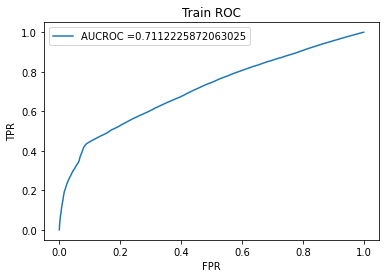

In [37]:
plt.figure()
x_val = [x[0] for x in point_train]
y_val = [x[1] for x in point_train]
plt.title('Train ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val,label=f'AUCROC ={evaluator.evaluate(trainpred,{evaluator.metricName:"areaUnderROC"})}')
plt.legend()
plt.show()

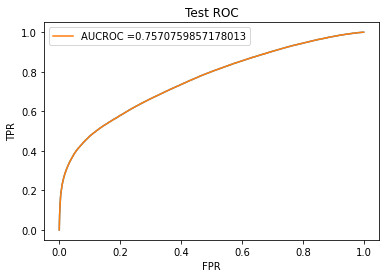

In [38]:
plt.figure()
x_val = [x[0] for x in point_test]
y_val = [x[1] for x in point_test]
plt.title('Test ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)
plt.plot(x_val, y_val,label=f'AUCROC ={evaluator.evaluate(testpred,{evaluator.metricName:"areaUnderROC"})}')
plt.legend()
plt.show()

#### Summary of the best Random Forest model

In [39]:
featureImp = rf_bestModel.featureImportances

In [40]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [41]:
imp = ExtractFeatureImp(featureImp,trainpred,'features')
imp.head(rf_bestModel._java_obj.getMaxDepth())

,idx,name,score
3,3,avg_shopping_expense_per_cat,0.461689
2,2,product_affinity,0.100755
5,5,sub_cat_views,0.073113
4,4,session_counts,0.062837
0,0,price,0.060061
1,1,user_activity,0.048234
29,29,sub_cat_enc_smartphone,0.013392
66,66,brand_reduced_enc_samsung,0.010070
15,15,hour_bin_enc_2,0.009485
17,17,main_cat_enc_electronics,0.009049


In [42]:
rf_bestModel._java_obj.getMaxDepth()

25

In [43]:
rf_bestModel._java_obj.getNumTrees()

25